In [139]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import pickle
import os
current_path = os.getcwd()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime, timedelta
import statistics
import time

import pymysql  
from haversine import haversine
from bisect import bisect_left, bisect_right

from geoband.API import *
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
import geoplot as gplt
import geoplot.crs as gcrs
import imageio
import mapclassify as mc

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
import pydeck as pdk
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import shapely
from shapely import wkt
from shapely.geometry import Polygon, Point, shape

# NLP 
import re
from konlpy.tag import Okt

!pip install glove_python
from glove import Corpus, Glove

# Crawling 
import requests
from bs4 import BeautifulSoup

# Clustering 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn import metrics
from scipy.spatial.distance import cdist

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'
plt.rc('axes', unicode_minus=False)

In [2]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

# 0. Data Load 

In [3]:
busdf = pd.read_excel(current_path+'/busdata/bus_final_0322.xlsx')

print(busdf.shape)
busdf.head(2)

(516, 123)


,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0,0,0,1,0,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4,4,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3,4,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7,0,0,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000,5.832431,6.927639,6.594444,7.260833,2.365833,7.491667,9.765833,13.972500,20.946667,25.994167,1.820833,6.397500,6.496667,10.760000,17.704167,16.250833,124.747167,178.410417,21,0,10,0,0.000000,1.000000,0.000000
1,200000008,문암골,0,0,0,1,0,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1,0,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1,0,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0,0,0,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857,6.176354,7.160278,7.342500,6.978056,1.715833,5.220833,9.853333,15.887500,22.269167,30.544167,1.487500,4.343333,5.940833,10.950000,20.195000,19.827500,132.046000,189.586667,0,0,0,0,0.000000,0.000000,0.000000


In [4]:
# 일자별 데이터 
Q1_df = pd.read_excel(current_path+'/busdata/bus_Q1_0322.xlsx')
Q2_df = pd.read_excel(current_path+'/busdata/bus_Q2_0322.xlsx')
Q3_df = pd.read_excel(current_path+'/busdata/bus_Q3_0322.xlsx')
Q4_df = pd.read_excel(current_path+'/busdata/bus_Q4_0322.xlsx')

In [5]:
final = pd.concat([Q1_df, Q2_df, Q3_df, Q4_df], axis=0)
print(final.shape)
final.head()

(1326103, 21)


,일자,정류소ID,노선번호,노선유형,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,상행운행시간,하행운행시간,운행노선수,정류장유형수,주중배차간격(분),주말배차간격(분),주중배차간격_15분,주중배차간격_60분,주말배차간격_15분,주말배차간격_60분,전체승하차건수,공휴일,주말
0,2020-01-01,200000006,13,일반형시내버스,166,160,6,67,57600,63000,9,1,6.000000,6.000000,1,0,1,0,233,1,0
1,2020-01-01,200000006,37,일반형시내버스,36,33,3,0,60600,61800,9,1,11.500000,17.500000,1,0,0,0,36,1,0
2,2020-01-01,200000006,7_1,일반형시내버스,187,162,25,190,63600,63900,9,1,8.000000,10.500000,1,0,1,0,377,1,0
3,2020-01-01,200000008,13,일반형시내버스,127,127,0,46,57600,63000,1,1,6.000000,6.000000,1,0,1,0,173,1,0
4,2020-01-01,200000036,112,일반형시내버스,36,34,2,76,64200,64200,1,2,8.000000,10.500000,1,0,1,0,112,1,0


In [6]:
busstop = pd.read_excel(current_path+'/busdata/busstop_0322.xlsx')

print(busstop.shape)
busstop.head(2)

(3926, 58)


,정류소ID,노선번호,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat,운행노선,중앙차로여부,노선ID,노선순서,관할관청,운행업체,기점,기점_STATION_ID,종점,종점_STATION_ID,주중배차간격,주말배차간격,상행첫차,상행막차,하행첫차,하행막차,상행운행시간,하행운행시간,운행노선수,정류장유형수,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,전체승하차건수,승차비율,환승비율,하차비율,승차많은버스,환승많은버스,하차많은버스
0,200000006,13,광교공원.경기대수원캠퍼스입구.연무시장,['시내'],일반,경기도 수원시 연무동,0,1,0,0,1,0,0,127.029464,37.300014,"['13(수원여객)', '16(수원여객)', '16-1(수원여객)', '16-2(수...",0,200000037,13,수원시,수원여객,상광교동종점,200000275,칠보고등학교.칠보중학교.극동스타클래스,201000099,5분~7분,5분~7분,06:00:00,22:00:00,05:40:00,23:10:00,0.666667,0.729167,9,1,212.605479,206.279452,6.326027,51.257534,0,0,0,1,0,0,32.608055,0.970245,4.024373,0.029755,0.123417,4.147790,263.863014,0.781767,0.023975,0.194258,1,0,0
1,200000006,37,광교공원.경기대수원캠퍼스입구.연무시장,['시내'],일반,경기도 수원시 연무동,0,1,0,0,1,0,0,127.029464,37.300014,"['13(수원여객)', '16(수원여객)', '16-1(수원여객)', '16-2(수...",0,200000099,1,수원시,수원여객,광교공원.경기대수원캠퍼스입구.연무시장,200000006,한국민속촌.보라해링턴,228001646,10분~13분,15분~20분,04:50:00,21:40:00,06:00:00,23:10:00,0.701389,0.715278,9,1,48.726027,43.556164,5.169863,4.813699,0,0,0,1,0,0,8.425013,0.893899,9.048378,0.106101,1.073990,10.122368,53.539726,0.813530,0.096561,0.089909,1,0,0


# 1. 일자별 기상 데이터 

In [7]:
weather = pd.read_csv(current_path+'/data/수원시기상정보.csv', encoding="CP949")

print(weather.shape)
weather.head()

(8784, 37)


,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),이슬점온도(°C),현지기압(hPa),현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),운형(운형약어),최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,119,수원,2020-01-01 00:00,-6.000000,nan,nan,9.000000,1.500000,nan,160.000000,nan,64,nan,2.500000,-11.700000,1029.100000,nan,1034.300000,nan,nan,9.000000,nan,nan,nan,9.000000,9.000000,Sc,14.000000,2000,nan,nan,-3.700000,nan,nan,nan,nan,nan
1,119,수원,2020-01-01 01:00,-6.300000,nan,nan,9.000000,2.400000,nan,160.000000,nan,74,nan,2.800000,-10.100000,1028.600000,nan,1033.800000,nan,nan,9.000000,nan,nan,nan,9.000000,9.000000,Sc,10.000000,1919,nan,5.000000,-3.800000,nan,nan,nan,nan,nan
2,119,수원,2020-01-01 02:00,-6.200000,nan,nan,9.000000,1.600000,nan,140.000000,nan,70,nan,2.700000,-10.700000,1028.200000,nan,1033.400000,nan,nan,9.000000,nan,nan,nan,6.000000,6.000000,Sc,10.000000,1955,nan,5.000000,-4.200000,nan,nan,nan,nan,nan
3,119,수원,2020-01-01 03:00,-5.800000,nan,0.000000,9.000000,1.600000,nan,160.000000,nan,65,nan,2.600000,-11.300000,1028.300000,nan,1033.500000,nan,nan,9.000000,nan,nan,nan,7.000000,7.000000,Sc,8.000000,2000,nan,nan,-4.100000,nan,nan,nan,nan,nan
4,119,수원,2020-01-01 04:00,-5.400000,nan,nan,9.000000,1.300000,nan,160.000000,nan,64,nan,2.600000,-11.100000,1028.300000,nan,1033.500000,nan,nan,9.000000,nan,nan,nan,9.000000,9.000000,Sc,5.000000,2000,nan,5.000000,-3.500000,nan,nan,nan,nan,nan


In [8]:
# 결측값 채우기 
weather = weather.fillna(0)

# 일자 data type 바꿔주기 
tqdm.pandas()
weather["일시"] = weather["일시"].progress_apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d %H:%M'))
weather["date"] = weather["일시"].progress_apply(lambda x : x.strftime('%Y%m%d'))

# 체감온도 : 13.12 + 0.6215T - 11.37V^0.16 + 0.3965V^0.16T (T : 기온(°C), V : 풍속(km/h))
weather["체감온도"] = weather.progress_apply(lambda x : 13.12 + 0.6215 * x['기온(°C)'] - 11.37 * (x['풍속(m/s)'] * 3.6)**0.16 + 0.3965 * (x['풍속(m/s)'] * 3.6)**0.16 * x['기온(°C)'], axis = 1)

# column drop 
weather = weather.drop(["지점", "지점명", '일시'], axis=1)

100%|██████████| 8784/8784 [00:00<00:00, 24841.90it/s]


In [9]:
# 최저기온 & 최고기온 
weather_tmp = weather.groupby(["date"]).agg({
    '기온(°C)' : [('최고기온', np.max), ('최저기온', np.min)], 
    '강수량(mm)' : [('최고강수량', np.max)], 
    '체감온도' : [("최고체감온도" , np.max), ("최저체감온도" , np.min)]
}).reset_index()

weather_tmp.columns = weather_tmp.columns.get_level_values(level=1)
weather_tmp = weather_tmp.rename(columns = {'' : "일자"})

weather_tmp["일자"] = weather_tmp["일자"].progress_apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

100%|██████████| 366/366 [00:00<00:00, 3170.13it/s]


In [10]:
print(weather_tmp.shape)
weather_tmp.head()

(366, 6)


,일자,최고기온,최저기온,최고강수량,최고체감온도,최저체감온도
0,2020-01-01,0.200000,-6.300000,0.000000,2.332181,-10.377334
1,2020-01-02,3.200000,-0.300000,0.000000,4.231197,-0.278337
2,2020-01-03,5.200000,-3.900000,0.000000,11.814850,-3.620122
3,2020-01-04,7.400000,-4.300000,0.000000,5.136829,-4.504902
4,2020-01-05,6.200000,-5.500000,0.000000,7.951185,-6.931294


In [11]:
final = final.merge(weather_tmp, on="일자", how="left")

In [13]:
final["전체승하차건수"] = final.progress_apply(lambda x : x["전체 승차 건수"] + x["전체 하차 건수"], axis=1)

100%|██████████| 1326103/1326103 [00:37<00:00, 35055.47it/s]


In [28]:
final[["log전체승하차건수"]] = np.log1p(final[["전체승하차건수"]])

# 2. 승하차 건수 ~ 일별 기상 데이터  
* 가정 : 날씨에 따라서 승하차 건수가 달라질 것이다 

In [141]:
import statsmodels.api as sm

X = final[['최고강수량', '최고체감온도']]
y = np.log1p(final[["전체승하차건수"]])

In [142]:
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                전체승하차건수   R-squared (uncentered):                   0.699
Model:                            OLS   Adj. R-squared (uncentered):              0.699
Method:                 Least Squares   F-statistic:                          1.539e+06
Date:                Wed, 24 Mar 2021   Prob (F-statistic):                        0.00
Time:                        17:08:04   Log-Likelihood:                     -2.9026e+06
No. Observations:             1326103   AIC:                                  5.805e+06
Df Residuals:                 1326101   BIC:                                  5.805e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 2-1. 일자별로 각 정류소 승하차 다 더한 데이터 만들기 

In [92]:
busnum = final.groupby(["일자", "정류소ID"]).sum().reset_index()[["일자","정류소ID","전체승하차건수"]]
busnum

,일자,정류소ID,전체승하차건수
0,2020-01-01,200000006,646
1,2020-01-01,200000008,173
2,2020-01-01,200000036,112
3,2020-01-01,200000047,187
4,2020-01-01,200000066,330
...,...,...,...
185549,2020-12-31,203000385,94
185550,2020-12-31,203000390,57
185551,2020-12-31,203000399,1209
185552,2020-12-31,203000439,1


In [93]:
busnum = busnum.merge(weather_tmp, on="일자", how="left")

## 2-2. 정류소 별 일자 데이터로 상관계수 구하기 

In [109]:
busnum.정류소ID.nunique()

516

In [113]:
busnum[busnum["정류소ID"] == 200000006].corr()

,정류소ID,전체승하차건수,최고기온,최저기온,최고강수량,최고체감온도,최저체감온도
정류소ID,nan,nan,nan,nan,nan,nan,nan
전체승하차건수,nan,1.000000,0.418098,0.296228,-0.194810,0.402356,0.322223
최고기온,nan,0.418098,1.000000,0.935258,0.190409,0.963594,0.945958
최저기온,nan,0.296228,0.935258,1.000000,0.278623,0.898821,0.994785
최고강수량,nan,-0.194810,0.190409,0.278623,1.000000,0.177766,0.261499
최고체감온도,nan,0.402356,0.963594,0.898821,0.177766,1.000000,0.916023
최저체감온도,nan,0.322223,0.945958,0.994785,0.261499,0.916023,1.000000


In [116]:
busnum[busnum["정류소ID"] == 200000006][['전체승하차건수', '최고강수량', '최고체감온도']].corr()

,전체승하차건수,최고강수량,최고체감온도
전체승하차건수,1.000000,-0.194810,0.402356
최고강수량,-0.194810,1.000000,0.177766
최고체감온도,0.402356,0.177766,1.000000


In [115]:
busnum[busnum["정류소ID"] == 200000008][['전체승하차건수', '최고강수량', '최고체감온도']].corr()

,전체승하차건수,최고강수량,최고체감온도
전체승하차건수,1.000000,-0.206834,0.225646
최고강수량,-0.206834,1.000000,0.177766
최고체감온도,0.225646,0.177766,1.000000


In [117]:
busnum[busnum["정류소ID"] == 200000036][['전체승하차건수', '최고강수량', '최고체감온도']].corr()

,전체승하차건수,최고강수량,최고체감온도
전체승하차건수,1.000000,-0.013023,0.087172
최고강수량,-0.013023,1.000000,0.177766
최고체감온도,0.087172,0.177766,1.000000


In [125]:
busdf["강수량상관관계"] , busdf["온도상관관계"] = .1, .1

for i in tqdm(range(len(busdf))) : 
    busid = busdf.정류소ID.iloc[i]
    corrmatrix = busnum[busnum["정류소ID"] == busid][['전체승하차건수', '최고강수량', '최고체감온도']].corr()
    busdf["강수량상관관계"].iloc[i] , busdf["온도상관관계"].iloc[i] = corrmatrix.iloc[0][1], corrmatrix.iloc[0][2]

100%|██████████| 516/516 [00:02<00:00, 187.68it/s]


In [135]:
busdf.head(3)

,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,고색동거리,광교동거리,신풍동거리,영통동거리,인계동거리,천천동거리,호매실동거리,강수량상관관계,온도상관관계
0,200000006,광교공원.경기대수원캠퍼스입구.연무시장,0,0,0,1,0,127.029464,37.300014,0,9,1,12.771369,0.909413,14.400385,0.090587,1.121787,15.522172,0.764578,0.075057,0.160365,601.614903,559.026465,42.588438,269.979548,0,0,0,8,0,0,7,0,0,17.833333,18.083333,98.312500,0.763982,0.063101,0.172917,807.824583,4,4,503.707749,7,0,0,4639.473467,11.500000,99.625000,0.766371,0.093460,0.140169,1021.791501,3,4,427.025438,7,0,0,6716.120271,17.500000,0.789157,0.074057,0.136786,885.335606,7,0,0,6002.522727,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,486.400000,368.370000,2.760000,115.240000,42.687500,67.075000,5.832431,6.927639,6.594444,7.260833,2.365833,7.491667,9.765833,13.972500,20.946667,25.994167,1.820833,6.397500,6.496667,10.760000,17.704167,16.250833,124.747167,178.410417,21,0,10,0,0.000000,1.000000,0.000000,6.709683,4.612747,2.373598,4.643121,2.437335,6.041080,8.369192,-0.194810,0.402356
1,200000008,문암골,0,0,0,1,0,127.027700,37.308946,0,1,1,258.513761,0.996147,2.109605,0.003853,0.008161,2.117766,0.676640,0.002617,0.320742,77.498630,77.200000,0.298630,36.594521,0,0,0,1,0,0,1,0,0,16.000000,17.500000,6.000000,0.767258,0.004407,0.228335,75.630522,1,0,167.500000,1,0,0,350.168675,6.000000,6.000000,0.599555,0.001160,0.399285,199.009615,1,0,167.500000,0,0,0,717.288462,6.000000,0.611576,0.000643,0.387781,172.777778,0,0,0,634.666667,3,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,156.265714,129.308571,0.402857,26.500000,60.881429,69.982857,6.176354,7.160278,7.342500,6.978056,1.715833,5.220833,9.853333,15.887500,22.269167,30.544167,1.487500,4.343333,5.940833,10.950000,20.195000,19.827500,132.046000,189.586667,0,0,0,0,0.000000,0.000000,0.000000,6.849480,4.915871,2.548656,5.232781,3.036157,5.924470,8.365801,-0.206834,0.225646
2,200000036,풍림아파트입구,1,0,0,1,0,126.995257,37.297929,0,1,2,10.415812,0.912402,0.673753,0.087598,0.064686,0.738438,0.387562,0.037209,0.575229,73.186301,66.775342,6.410959,99.109589,0,0,0,1,0,0,0,0,0,17.833333,17.833333,8.000000,0.390197,0.039952,0.569850,195.915663,1,0,133.750000,0,0,0,674.184739,8.000000,10.500000,0.381641,0.028005,0.590354,123.605769,1,0,101.904762,0,0,0,531.663462,10.500000,0.352423,0.024229,0.623348,100.888889,0,0,0,399.000000,1,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,0,3954133,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1989,84,1,29000,341,275.866667,191.766667,1.320000,82.740000,49.613333,75.261667,2.775660,4.122361,2.787222,5.457500,2.625000,4.275000,6.124167,8.574167,8.933333,7.345833,2.758333,3.272500,3.898333,7.241667,6.602500,4.957500,69.235167,60.162500,0,41,331,49,0.097387,0.786223,0.116390,3.702636,8.391093,1.935795,7.598513,4.372229,2.244175

In [127]:
busdf.강수량상관관계.describe()

count   516.000000
mean     -0.015773
std       0.046325
min      -0.206834
25%      -0.041720
50%      -0.016531
75%       0.015352
max       0.123799
Name: 강수량상관관계, dtype: float64

In [128]:
busdf.온도상관관계.describe()

count   516.000000
mean      0.081547
std       0.130698
min      -0.426533
25%       0.011120
50%       0.062069
75%       0.147575
max       0.499800
Name: 온도상관관계, dtype: float64

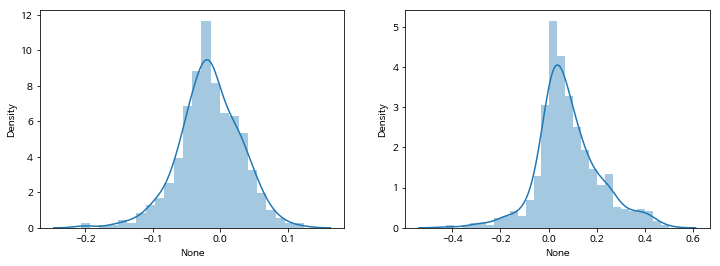

In [140]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.distplot(busdf[["강수량상관관계"]], ax=ax1)
sns.distplot(busdf[["온도상관관계"]],ax=ax2)

In [134]:
busdf[busdf.온도상관관계 == 0.4997995496959633]

,정류소ID,정류장명,쉘터,LED,LCD,LED+LCD복합형,알뜰형,lon,lat,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,nlp_cluster,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,고색동거리,광교동거리,신풍동거리,영통동거리,인계동거리,천천동거리,호매실동거리,강수량상관관계,온도상관관계
50,200000169,경기대수원캠퍼스입구.연무시장,0,0,1,0,0,127.030036,37.299765,0,6,1,1.375569,0.564618,0.082733,0.435382,0.069596,0.152329,0.069012,0.057213,0.873775,90.525103,44.609429,45.915674,368.085416,0,0,0,6,0,0,0,0,5,17.500000,18.000000,127.833333,0.067349,0.062072,0.870579,416.717561,2,4,282.199597,0,0,5,496.547849,11.000000,128.166667,0.073069,0.046013,0.880917,557.880024,2,4,267.549247,0,0,5,792.766614,13.000000,0.065895,0.037157,0.896948,478.003030,0,0,5,652.630303,2,49.458333,24.166667,0.018250,0.034458,0.003042,0.704167,0,3954133,61.000000,36.333333,39.666667,60.833333,28.333333,15.666667,17.166667,35.500000,2003,75,4,21700,288,437.193333,337.500000,2.440000,97.280000,58.496667,76.208333,10.710243,13.599167,13.434167,13.764167,7.312500,14.378333,21.567500,30.197500,31.882500,38.512500,7.025000,11.234167,13.150833,21.560833,28.862500,31.349167,244.252500,289.740417,357,0,8,0,0.000000,1.000000,0.000000,6.757971,4.547460,2.423112,4.589613,2.423727,6.103309,8.426086,-0.149332,0.499800


# 3. 미세먼지 데이터 
* 이것도 넣으면 좋을 것 같은데 ㅠ_ㅠ ...

In [39]:
dust_loc = df_11.drop_duplicates(["측정소", "lon", "lat"], keep="first").reset_index()
dust_loc = dust_loc[["측정소", "lon", "lat"]]

# 에어코리아 데이터에 없는 동수원 측정소 삭제 
dust_loc = dust_loc[dust_loc["측정소"] != "동수원"].reset_index(drop=True)

print(dust_loc.shape)
dust_loc

(7, 3)


,측정소,lon,lat
0,고색동,126.976384,37.252329
1,광교동,127.070615,37.291321
2,신풍동,127.010465,37.283850
3,영통동,127.056294,37.246901
4,인계동,127.028723,37.263637
5,천천동,126.975305,37.292877
6,호매실동,126.957008,37.266153


In [40]:
def dist(bus, dust, dong):
    
    ''' 
    측정소랑 버스정류장 사이의 거리 구하는 함수
    dong: '동이름' 으로 설정하기 
    '''
    
    bus[dong+"거리"] = 0
    end = (dust[dust['측정소'] == dong]['lon'], dust[dust['측정소']== dong]['lat'])
    
    for i in range(len(bus)):
        start_lon, start_lat = bus["lon"].iloc[i], bus["lat"].iloc[i]
        start=(start_lon,start_lat)
        km=haversine(start,end,unit="km")
        bus[dong+"거리"].iloc[i]=km

In [41]:
# 각 동의 측정소와 버스정류장 사이의 거리 구하기
for i in dust_loc['측정소'].unique():
    dist(busdf, dust_loc, i)

In [42]:
locs = list(dust_loc["측정소"])

In [56]:
def dust1(month, dust_type="dust") : 

    '''
    에어코리아 일별 미세먼지 정보 크롤링 
    '''
    
    if dust_type == "dust": 
        code = 10007 # dust (PM10)
    else : 
        code = 10008 # microdust (PM2.5)
        
        
    url = f"https://www.airkorea.or.kr/web/sidoAirInfo/sidoAirInfoDay30ByLast?itemCode={code}&areaCode=031&tDate=2020-{month}-01&monthDay=31&tYear=2020&tDt={month}"
    payload={}
        
    headers = {
      'Cookie': f'JSESSIONID=AnrW81RXFCe9NzGRc7yB7mD7GnEeCqDbgJOuaWXoArKZx2vrJsaFpH1RGRWiT7xk.airwas2_servlet_newairkorea2; WMONID=ZEWH_QYKHxh'
    }              
        
    response = requests.request("GET", url, headers=headers, data=payload)
    html = response.text 
    soup = BeautifulSoup(html, 'html.parser')
    
    
    place_list = [] 
    places = soup.select("tr") # tr / td .. 
    for place in places : 
        place = re.sub(r'\n', '', place.text)
        place_list.append(place)
        
    dust_list = [] 
    for pl in place_list : 
        dust_list.append(pl.split())
        
    dust_dict = dict() 
    for dst in dust_list : 
        if dst[0] in locs : 
            dust_dict[dst[0]] = dst[1:]
            
    # 측정되지 않은 날짜 처리 
    for loc, dusts in dust_dict.items() : 
        if len(dusts) != 31 : 
            dusttt = [] 
            for dust in dusts : 
                if '-' not in dust : 
                    dusttt.append(dust)
                else : 
                    num = dust.find('-')
                    l = len(dust)
                    dust = re.sub(r'-', '', dust)                        
                    dusttt.extend([dust] * (l-num+1)) 
                    
            dust_dict[loc] = dusttt
            
    dust_dict = pd.DataFrame(dust_dict)
    
    if int(month) in [1,3,5,7,8,10,12] : 
        date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-31')
    elif int(month) in [4,6,9,11] : 
        dust_dict = dust_dict[:30]
        date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-30')
    else : 
        dust_dict = dust_dict[:29]
        date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-29')
        
    dust_dict.index = date_range
    
    return dust_dict


In [58]:
dust1('02', dust_type="dust") 

,고색동,광교동,신풍동,영통동,인계동,천천동,호매실동
2020-02-01,66,67,74,74,69,78,75
2020-02-02,60,68,68,69,66,72,64
2020-02-03,28,26,27,27,25,27,27
2020-02-04,36,27,29,28,25,29,33
2020-02-05,27,20,24,25,21,24,23
2020-02-06,39,38,43,40,38,44,44
2020-02-07,36,42,48,45,44,43,43
2020-02-08,37,37,40,43,37,42,39
2020-02-09,32,34,34,35,31,34,34
2020-02-10,44,46,52,50,48,52,52


In [70]:
def dust2(month, dust_type="dust") : 

    '''
    에어코리아 일별 미세먼지 정보 크롤링 
    '''
    
    if dust_type == "dust": 
        code = 10007 # dust (PM10)
    else : 
        code = 10008 # microdust (PM2.5)
        
        
    url = f"https://www.airkorea.or.kr/web/sidoAirInfo/sidoAirInfoDay30ByLast?itemCode={code}&areaCode=031&tDate=2020-{month}-01&monthDay=31&tYear=2020&tDt={month}"
    payload={}
        
    headers = {
      'Cookie': f'JSESSIONID=PfGEdNJPn8pm55AanuOZv2QehvTBsvhi9ZVjVbGuGMZPehjxJjlRRTkmXSN5QEFd.airwas2_servlet_newairkorea2; WMONID=ZEWH_QYKHxh'
    }              
        
    response = requests.request("GET", url, headers=headers, data=payload)
    html = response.text 
    soup = BeautifulSoup(html, 'html.parser')
    
    
    place_list = [] 
    places = soup.select("tr") # tr / td .. 
    for place in places : 
        place = re.sub(r'\n', ' ', place.text)
        place_list.append(place)
        
    dust_list = [] 
    for pl in place_list : 
        dust_list.append(pl.split())
        
    dust_dict = dict() 
    for dst in dust_list : 
        if dst[2] in locs : 
            dust_dict[dst[2]] = dst[3:]
            
    # 측정되지 않은 날짜 처리 
    for loc, dusts in dust_dict.items() : 
        if len(dusts) != 31 : 
            dusttt = [] 
            for dust in dusts : 
                if '-' not in dust : 
                    dusttt.append(dust)
                else : 
                    num = dust.find('-')
                    l = len(dust)
                    dust = re.sub(r'-', '', dust)                        
                    dusttt.extend([dust] * (l-num+1)) 
                    
            dust_dict[loc] = dusttt
            
#     dust_dict = pd.DataFrame(dust_dict)
    
#     if int(month) in [1,3,5,7,8,10,12] : 
#         date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-31')
#     elif int(month) in [4,6,9,11] : 
#         dust_dict = dust_dict[:30]
#         date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-30')
#     else : 
#         dust_dict = dust_dict[:29]
#         date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-29')
        
#     dust_dict.index = date_range
    
    return dust_list


In [71]:
dust2('12', dust_type="dust")

[['지점',
  '2020-12-01',
  '2020-12-02',
  '2020-12-03',
  '2020-12-04',
  '2020-12-05',
  '2020-12-06',
  '2020-12-07',
  '2020-12-08',
  '2020-12-09',
  '2020-12-10',
  '2020-12-11',
  '2020-12-12',
  '2020-12-13',
  '2020-12-14',
  '2020-12-15',
  '2020-12-16',
  '2020-12-17',
  '2020-12-18',
  '2020-12-19',
  '2020-12-20',
  '2020-12-21',
  '2020-12-22',
  '2020-12-23',
  '2020-12-24',
  '2020-12-25',
  '2020-12-26',
  '2020-12-27',
  '2020-12-28',
  '2020-12-29',
  '2020-12-30',
  '2020-12-31'],
 ['가남읍',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 ['가평',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 ['경안동',
  '-',
  '-',
  '-',
  '-',
  '-'

In [50]:
def dust(month, dust_type="dust", nd=True) : 

    '''
    에어코리아 일별 미세먼지 정보 크롤링 
    '''
    
    if dust_type == "dust": 
        code = 10007 # dust (PM10)
    else : 
        code = 10008 # microdust (PM2.5)

        
    # 11월 & 12월 
    i, cookie = 0, ''
    if nd : 
        i = 0 
        cookie = 'AnrW81RXFCe9NzGRc7yB7mD7GnEeCqDbgJOuaWXoArKZx2vrJsaFpH1RGRWiT7xk'
    else : 
        i = 2
        cookie = 'PfGEdNJPn8pm55AanuOZv2QehvTBsvhi9ZVjVbGuGMZPehjxJjlRRTkmXSN5QEFd'
        
        
        
    url = f"https://www.airkorea.or.kr/web/sidoAirInfo/sidoAirInfoDay30ByLast?itemCode={code}&areaCode=031&tDate=2020-{month}-01&monthDay=31&tYear=2020&tDt={month}"
    payload={}
        
    headers = {
      'Cookie': f'JSESSIONID={cookie}.airwas2_servlet_newairkorea2; WMONID=ZEWH_QYKHxh'
    }              
        
    response = requests.request("GET", url, headers=headers, data=payload)
    html = response.text 
    soup = BeautifulSoup(html, 'html.parser')
    
    
    place_list = [] 
    places = soup.select("tr") # tr / td .. 
    for place in places : 
        if nd : 
            place = re.sub(r'\n', '', place.text)
        else : 
            place = re.sub(r'\n', ' ', place.text)
        place_list.append(place)
        
    dust_list = [] 
    for pl in place_list : 
        dust_list.append(pl.split())
        
    dust_dict = dict() 
    for dst in dust_list : 
        if dst[i] in locs : 
            dust_dict[dst[i]] = dst[(i+1):]
            
    # 측정되지 않은 날짜 처리 
    for loc, dusts in dust_dict.items() : 
        if len(dusts) != 31 : 
            dusttt = [] 
            for dust in dusts : 
                if '-' not in dust : 
                    dusttt.append(dust)
                else : 
                    num = dust.find('-')
                    l = len(dust)
                    dust = re.sub(r'-', '', dust)                        
                    dusttt.extend([dust] * (l-num+1)) 
                    
            dust_dict[loc] = dusttt
            
#    dust_dict = pd.DataFrame(dust_dict)
    
#     if int(month) in [1,3,5,7,8,10,12] : 
#         date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-31')
#     elif int(month) in [4,6,9,11] : 
#         dust_dict = dust_dict[:30]
#         date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-30')
#     else : 
#         dust_dict = dust_dict[:29]
#         date_range = pd.date_range(f'2020-{month}-01', f'2020-{month}-29')
        
#     dust_dict.index = date_range
    
    return dust_list


In [51]:
dust('11', nd=False)

[['지점',
  '2020-11-10',
  '2020-11-11',
  '2020-11-12',
  '2020-11-13',
  '2020-11-14',
  '2020-11-15',
  '2020-11-16',
  '2020-11-17',
  '2020-11-18',
  '2020-11-19',
  '2020-11-20',
  '2020-11-21',
  '2020-11-22',
  '2020-11-23',
  '2020-11-24',
  '2020-11-25',
  '2020-11-26',
  '2020-11-27',
  '2020-11-28',
  '2020-11-29',
  '2020-11-30'],
 ['가남읍',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 ['가평',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 ['경안동',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-

In [19]:
def dust2(month, dust_type=True) : 

    '''
    에어코리아 일별 미세먼지 정보 크롤링 
    11월, 12월 데이터 
    '''
    
    if dust_type : 
        code = 10007 # dust (PM10)
    else : 
        code = 10008 # microdust (PM2.5)

    url = f"https://www.airkorea.or.kr/web/sidoAirInfo/sidoAirInfoDay30?areaCode=031&itemCode={code}&ymd=2020-{month}-30&tDate=2020-{month}-01"

    payload={}
    headers = {
      'Cookie': 'JSESSIONID=PfGEdNJPn8pm55AanuOZv2QehvTBsvhi9ZVjVbGuGMZPehjxJjlRRTkmXSN5QEFd.airwas2_servlet_newairkorea2; WMONID=ZEWH_QYKHxh'
    }    
    
    
    response = requests.request("GET", url, headers=headers, data=payload)
    html = response.text 
    soup = BeautifulSoup(html, 'html.parser')
    
    place_list = [] 
    places = soup.select("tr") # tr / td .. 
    for place in places : 
        place = re.sub(r'\n', ' ', place.text)
        place_list.append(place)
        
    dust_list = [] 
    for pl in place_list : 
        dust_list.append(pl.split())
        
    dust_dict = dict() 
    for dst in dust_list : 
        if dst[2] in locs : 
            dust_dict[dst[2]] = dst[3:]

    # 측정되지 않은 날짜 처리 
    for loc, dusts in dust_dict.items() : 
        if len(dusts) != 31 : 
            dusttt = [] 
            for dust in dusts : 
                if '-' not in dust : 
                    dusttt.append(dust)
                else : 
                    num = dust.find('-')
                    l = len(dust)
                    
                    dust = re.sub(r'-', '', dust)
                    dusttt.extend([dust] * (l-num+1)) 
                    
            dust_dict[loc] = dusttt            
            
    return dust_dict


In [ ]:
dust2('11', dust_type=False)